<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/passo03_treino_BERTimbau_fakebr_corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Treino e Avaliação BERTimbau com Fake.BR Corpus

### Configuração para rodar no Goolge Colab    
O treinamento no Colab levou pouco menos de uma hora, enquanto no computador local indicou que levaria mais de 2 dias.   
As primeiras célucas devem ser executadas para instalar a arquitetura de transformers e liberar o acesso ao drive do Colab.  
O arquivo .csv de entrada pode ser enviado por upload.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 70.6 MB/s 
     |████████████████████████████████| 880 kB 78.2 MB/s 
     |████████████████████████████████| 6.6 MB 52.4 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 275 kB 4.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importação de bibliotecas utilizadas no treino e avaliação
import datetime
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay, roc_curve)
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformers import (BertForSequenceClassification, BertTokenizer,
                          get_linear_schedule_with_warmup)
from transformers.file_utils import is_torch_available

%matplotlib inline

### Carrega dados processados no passo 1

In [ ]:
PLANILHA_DATASET = r'/content/drive/MyDrive/PUC/TCC/dados/fakebr_corpus_processado.csv'
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
dados_processado = pd.read_csv(PLANILHA_DATASET, sep = ',')
dados_processado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7074 entries, 0 to 7073
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Unnamed: 0             7074 non-null   int64 
 1   texto                  7074 non-null   object
 2   classe                 7074 non-null   int64 
 3   texto_limpo            7074 non-null   object
 4   texto_processado       7074 non-null   object
 5   qtde_texto_limpo       7074 non-null   int64 
 6   qtde_texto_processado  7074 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 387.0+ KB


In [ ]:
dados_processado[['classe','texto','texto_processado','qtde_texto_processado']].sample(n=3)

,classe,texto,texto_processado,qtde_texto_processado
5221,1,"Tem gente que é tão pobre, que só tem dinheiro! Blogueira Kéfera divulga vídeo e faz piada infame com Deus. Enquanto você trabalha, estuda e se esforça para ser um profissional bem sucedido, há p...","gente pobre , dinheiro ! Blogueira Kéfera divulgar vídeo piar infamar Deus . trabalhar , estudar esforçar profissional suceder , haver pessoa aparecer , repente , tornar sucesso . blogueira Kéfera...",141
3053,0,"Dicionário do Oscar: O que cada categoria técnica premia?. Conheça prêmios como Melhor fotografia, edição e design de produção – não tão glamurosos, mas responsáveis por reconhecer centenas de pro...","Dicionário Oscar : categoria técnico premir ? . Conheça prêmios Melhor fotografia , edição design produção – glamurosos , responsável reconhecer centena profissional trabalhar trás câmeras . basti...",119
5327,1,"Marina quer novas eleições! De 4 em 4 anos ela aparece para ajudar Lula! A Rede é PT!. Derrotada nas eleições presidenciais de 2010 e 2014, a ""chefona"" do partido REDE defendeu que sejam convoca...","Marina eleição ! 4 4 ano aparecer ajudar Lula ! Rede PT ! . Derrotada eleição presidencial 2010 2014 , "" chefão "" partir REDE defender ser convocar eleição . Marina pessoa incrível . chamar candid...",167


### Geração de seed  
Com esta rotina consigo garantir a reprodução dos resultados mesmo que o ambiente for reiniciado
Aplicável às libs random, numpy e torch

In [ ]:
RANDOM_SEED = 42
def garantir_reprodutividade(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            return "cuda"
    return "cpu"

device = garantir_reprodutividade(RANDOM_SEED)

### Carregando o modelo pré-treinado BERTimbau

In [ ]:
MODELO_BERT = "neuralmind/bert-base-portuguese-cased"
model = BertForSequenceClassification.from_pretrained(MODELO_BERT, num_labels=2, output_attentions=False, output_hidden_states=False)
tokenizer = BertTokenizer.from_pretrained(MODELO_BERT, do_lower_case=False)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

### Tokeniza textos

In [ ]:
dados_token = dados_processado[['classe','texto_processado']].copy()
dados_token['TOKENS'] = dados_token['texto_processado'].apply(lambda x: np.array(tokenizer.encode(x, padding='max_length', truncation=True, max_length=400)))
dados_token['LABELS'] = dados_token['classe']
dados_token = dados_token[['TOKENS','LABELS']]

### Separando treino, teste e validação

In [ ]:
# Divido em 70% para treino e 20% para validação e o restante para teste, fracionado aleatoriamente e com random seed 42
dados_treino, dados_validacao, dados_teste = np.split(dados_token.sample(frac=1), [int(.7*len(dados_token)), int(.8*len(dados_token))])
display(f"Treinamento: {dados_treino.shape[0]}, Teste: {dados_teste.shape[0]}, Validação: {dados_validacao.shape[0]}")

'Treinamento: 4951, Teste: 1415, Validação: 708'

### Geração dos tensores

In [ ]:
treino_valores = torch.tensor(dados_treino['TOKENS'].values.tolist()).to(torch.int64)
treino_classes = torch.tensor(np.array(dados_treino.LABELS.values)).to(torch.int64)
validacao_valores = torch.tensor(dados_validacao['TOKENS'].values.tolist()).to(torch.int64)
validacao_classes = torch.tensor(np.array(dados_validacao.LABELS.values)).to(torch.int64)
teste_valores = torch.tensor(dados_teste['TOKENS'].values.tolist()).to(torch.int64)
teste_classes = torch.tensor(np.array(dados_teste.LABELS.values)).to(torch.int64)

### Preparando o fine-tunning do modelo BERTimbau

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

epocas = 3 #antes 5
tamanho_lote = 16

# gera dataset e leitor de dados de treino
treino_dados = TensorDataset(treino_valores, treino_classes)
treino_leitor = DataLoader(treino_dados, sampler=RandomSampler(treino_dados), batch_size=tamanho_lote)
# gera dataset e leitor de dados de validação
validacao_dados = TensorDataset(validacao_valores, validacao_classes)
validacao_leitor = DataLoader(validacao_dados, sampler=SequentialSampler(validacao_dados), batch_size=tamanho_lote)

In [ ]:
# coleca modelo no divice disponível (cuda para GPU)
model.to(device)

passos_total = len(treino_leitor) * epocas
# configuração do otimizador e do scheduler para controlar hyperparametros
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = passos_total)

In [ ]:
estatisticas = []
inicio_total = time.time()

for epoca in range(0, epocas):
    print('\n======== Época {:} / {:} ========'.format(epoca + 1, epocas))
    print('Treinando...')
    inicio_processo = time.time()

    # Reinicia o loss a cada época
    loss_por_epoca = 0
    model.train()
    for passo, lote in enumerate(treino_leitor):
        if passo % 40 == 0 and not passo == 0:
            tempo = format_time(time.time() - inicio_processo)

            print('  Passo {:>5,}  de  {:>5,}.  Tempo decorrido: {:}.'.format(passo, len(treino_leitor), tempo))

        lote_valores = lote[0].to(device)
        lote_classes = lote[1].to(device)

        model.zero_grad()

        outputs = model(lote_valores,
                             token_type_ids=None,
                             labels=lote_classes)
        loss_por_epoca += outputs.loss.item()
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calcula a média do loss sobre todos lotes
    loss_treino_media = loss_por_epoca / len(treino_leitor)

    tempo_por_epoca = format_time(time.time() - inicio_processo)
    print("\n  Média do loss de treino: {0:.2f}".format(loss_treino_media))
    print("  Tempo do treino: {:}".format(tempo_por_epoca))

    print("\nValidando...")
    inicio_processo = time.time()

    # Coloca o modelo em modo de validação
    model.eval()

    # reseta variáveis para validação por epoca
    validacao_acuracia_total = 0
    validacao_loss_total = 0

    for lote in validacao_leitor:

        lote_valores = lote[0].to(device)
        lote_classes = lote[1].to(device)

        with torch.no_grad():

            outputs = model(lote_valores,
                                   token_type_ids=None,
                                   labels=lote_classes)

        classes_previstas = outputs.logits.detach().cpu().numpy()
        classes = lote_classes.to('cpu').numpy()
        predicao = np.argmax(classes_previstas, axis=1).flatten()
        classes = classes.flatten()
        validacao_acuracia_total += np.sum(predicao == classes) / len(classes)

    # mostra a acurácia de cada avaliação.
    validacao_acuracia_media = validacao_acuracia_total / len(validacao_leitor)
    print("  Acurácia: {0:.2f}".format(validacao_acuracia_media))

    # calcula a média da perda nos lotes.
    validacao_loss_medio = validacao_loss_total / len(validacao_leitor)

    # mede o tempo de cada avaliação.
    validation_time = format_time(time.time() - inicio_processo)

    print("  Loss de validação: {0:.2f}".format(validacao_loss_medio))
    print("  Tempo de validação: {:}".format(validation_time))

    # grava as estatísticas por época.
    estatisticas.append(
        {
            'epoca': epoca + 1,
            'Loss de Treinamento': loss_treino_media,
            'Loss de Validação': validacao_loss_medio,
            'Acurácia de Validação': validacao_acuracia_media,
            'Tempo de Treino': tempo_por_epoca,
            'Tempo de Validação': validation_time
        }
    )
print("\nTreinamento completo!")
print("Tempo total do treino {:} (h:mm:ss)".format(format_time(time.time()-inicio_total)))


======== Época 1 / 5 ========
Treinando...
  Passo    10  de    310.  Tempo decorrido: 0:00:07.
  Passo    20  de    310.  Tempo decorrido: 0:00:13.
  Passo    30  de    310.  Tempo decorrido: 0:00:19.
  Passo    40  de    310.  Tempo decorrido: 0:00:26.
  Passo    50  de    310.  Tempo decorrido: 0:00:32.
  Passo    60  de    310.  Tempo decorrido: 0:00:38.
  Passo    70  de    310.  Tempo decorrido: 0:00:45.
  Passo    80  de    310.  Tempo decorrido: 0:00:51.
  Passo    90  de    310.  Tempo decorrido: 0:00:58.
  Passo   100  de    310.  Tempo decorrido: 0:01:04.
  Passo   110  de    310.  Tempo decorrido: 0:01:10.
  Passo   120  de    310.  Tempo decorrido: 0:01:17.
  Passo   130  de    310.  Tempo decorrido: 0:01:23.
  Passo   140  de    310.  Tempo decorrido: 0:01:29.
  Passo   150  de    310.  Tempo decorrido: 0:01:36.
  Passo   160  de    310.  Tempo decorrido: 0:01:42.
  Passo   170  de    310.  Tempo decorrido: 0:01:48.
  Passo   180  de    310.  Tempo decorrido: 0:01:55.
  

### Validação do Modelo tunado

In [ ]:
# gera dataset e leitor de dados de teste
teste_dados = TensorDataset(teste_valores, teste_classes)
teste_leitor = DataLoader(teste_dados, sampler=SequentialSampler(teste_dados), batch_size=tamanho_lote)
# Colocar o modelo em modo de avaliação
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
classes_previstas , classes_verdadeiras = [], []

for lote in teste_leitor:
    # coloca o lote na GPUS
    lote = tuple(t.to(device) for t in lote)

    lote_valores, lote_classes = lote

    with torch.no_grad():
        outputs = model(lote_valores, token_type_ids=None)

    # Adiciona as prediões e as classes para a CPU
    outputs = outputs.logits.detach().cpu().numpy()
    classes = lote_classes.to('cpu').numpy()

    # Salva as predições e as classes corretos
    classes_previstas.append(outputs)
    classes_verdadeiras.append(classes)      

In [ ]:
# prepara resultado
lista_previsoes = np.concatenate(classes_previstas, axis=0)
lista_previsoes = np.argmax(lista_previsoes, axis=1).flatten()
lista_classes_verdadeiras = np.concatenate(classes_verdadeiras, axis=0)

### Relatório de classificação

In [ ]:
print(classification_report(lista_classes_verdadeiras, lista_previsoes,target_names=['confiável','falso']))

              precision    recall  f1-score   support

   confiável       0.98      0.97      0.98       701
       falso       0.98      0.98      0.98       714

    accuracy                           0.98      1415
   macro avg       0.98      0.98      0.98      1415
weighted avg       0.98      0.98      0.98      1415



### Curva ROC

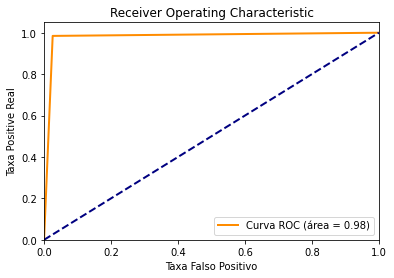

In [ ]:
fpr, tpr, _ = roc_curve(lista_classes_verdadeiras, lista_previsoes)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa Falso Positivo')
plt.ylabel('Taxa Positive Real')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Gráfico da Acurácia

In [ ]:
print(accuracy_score(lista_classes_verdadeiras, lista_previsoes))

0.9795053003533569


### Matriz de confusão

[[683  18]
 [ 11 703]]


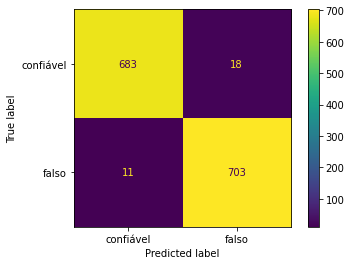

In [ ]:
conf = confusion_matrix(lista_classes_verdadeiras, lista_previsoes)
print(conf)
cmd = ConfusionMatrixDisplay(conf, display_labels=['confiável','falso'])
cmd.plot()

### Gera as estatísticas do treino

In [ ]:
# Cria um dataframe das estatísticas
pd.set_option('precision', 2)
df_estatisticas = pd.DataFrame(data=estatisticas)
df_estatisticas = df_estatisticas.set_index('epoca')

### Curva de aprendizado

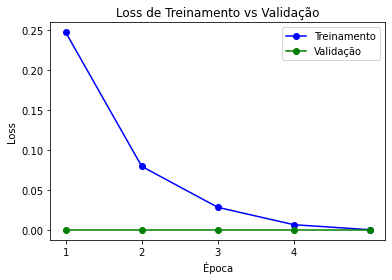

In [ ]:
plt.figure()
# Mostra curva de aprendizado.
plt.plot(df_estatisticas['Loss de Treinamento'], 'b-o', label="Treinamento")
plt.plot(df_estatisticas['Loss de Validação'], 'g-o', label="Validação")
plt.title("Loss de Treinamento vs Validação")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

### Acurácia

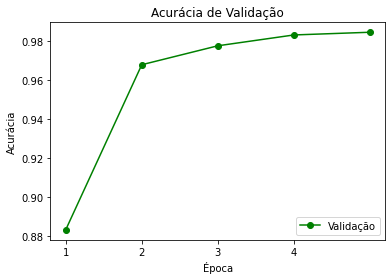

In [ ]:
plt.figure()
plt.plot(df_estatisticas['Acurácia de Validação'], 'g-o', label="Validação")
plt.title("Acurácia de Validação")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend(loc="lower right")
plt.xticks([1, 2, 3, 4])
plt.show()

### Salvando o melhor modelo

In [ ]:
CAMINHO_MODELO = "drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias"
model.save_pretrained(f"{CAMINHO_MODELO}")
tokenizer.save_pretrained(f"{CAMINHO_MODELO}")

('drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias/tokenizer_config.json',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias/special_tokens_map.json',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias/vocab.txt',
 'drive/MyDrive/PUC/TCC/modelos/bertimbau_avaliar_noticias/added_tokens.json')